In [1]:
#----------------------------
# import libraries
#----------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
def reserve_test_set(df, ratio):
    # shuffle array
    df = shuffle(df)
    # calculate number of samples in test set
    N = round( ratio * df.shape[0] )
    # split dataframe
    test_set = df.iloc[:N, :]
    df = df.iloc[N:, :]
    return test_set, df

In [3]:
def logistic_function(x):
    N = x.shape[0]
    ŷ = np.zeros(shape=(N,1))
    for i in range(N):
        ŷ[i] = 1 / (1 + np.exp(x[i]))
    return ŷ

In [4]:
def iterate(x, y, N, phi, w, alpha):
    # calculate estimated output
    ŷ = logistic_function(- phi @ w)
    # calculate gradient
    error = y - ŷ
    gradient = -1/N * (error.T @ phi)
    # calculate RMSE
    rmse = np.mean(error * error)
    w = w - (alpha * gradient.T)
    return w, rmse

In [5]:
def train(x, y, alpha=1e-2, tolerance=1e-4):
    # alpha: step size
    # tolerance: stop criteria
    #-----------------------------
    # create weights array randomly
    w = np.random.rand(x.shape[1]+1)
    w = w.reshape(1,len(w)).T
    # arrays initialization
    N = x.shape[0]
    phi = np.insert(x, 0, [1], axis=1)
    e = []
    #-----------------------------
    # run algorithm first time
    w, rmse = iterate(x, y, N, phi, w, alpha)
    diff = rmse
    e.append(rmse)
    #-----------------------------
    # iterate until convergence
    while (diff > tolerance):
        w, rmse = iterate(x, y, N, phi, w, alpha)
        diff = e[-1] - rmse
        e.append(rmse)
    #-----------------------------        
    return w, e

In [6]:
def predict_class(y, threshold):
    y_final = np.zeros(shape=(len(y),1))
    for i in range(len(y)):
        if (y[i] > threshold):
            y_final[i] = 1
        else:
            y_final[i] = 0
    return y_final

In [7]:
# path to save figures
path = 'figures/ex1/'
# read data
df = pd.read_csv('dados_voz_genero.csv')
# remove index column
df = df.drop(df.columns[[0]], axis=1)
# dataframe to numpy
features = df.to_numpy()

In [8]:
# split data according to the label
df_male = df[df['label'] == 1]
df_female = df[df['label'] == 0]

In [9]:
ratio = 0.2
# shuffle and reserve set for test
df_test_female, df_female = reserve_test_set(df_female, ratio)
df_test_male, df_male = reserve_test_set(df_male, ratio)

In [10]:
# concatenate and shuffle test set
df_test_set = [df_test_male, df_test_female]
df_test_set = pd.concat(df_test_set)
df_test_set = shuffle(df_test_set)

In [11]:
# concatenate and shuffle test set
df_train_set = [df_male, df_female]
df_train_set = pd.concat(df_train_set)
df_train_set = shuffle(df_train_set)

In [12]:
# data standardization: x' = (x - u) / s
scaler = StandardScaler()
#-------------------
# in training set
#-------------------
# remove column 'label' from x data
df_train_set_x = df_train_set.drop('label', axis=1)
# define column 'label' as output y
df_train_set_y = df_train_set.loc[:,'label']
# perform standardization with x data
scaler.fit(df_train_set_x)
train_set = scaler.transform(df_train_set_x)
#-------------------
# in test set
#-------------------
# remove column 'label' from x data
df_test_set_x = df_test_set.drop('label', axis=1)
# define column 'label' as output y
df_test_set_y = df_test_set.loc[:,'label']
# perform standardization with x data
scaler.fit(df_test_set_x)
test_set = scaler.transform(df_test_set_x)

In [13]:
# prepare input and output of model for training set
y = pd.DataFrame.to_numpy(df_train_set_y)
y = y.reshape(len(y),1)
x = train_set

In [14]:
w, error = train(x, y, tolerance=1e-6)

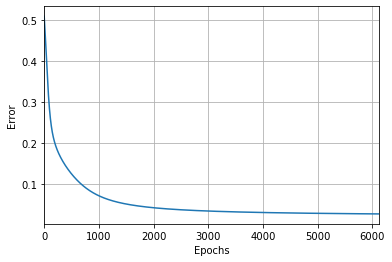

In [15]:
plt.plot(error)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

In [16]:
# prepare input and output of model for test set
y = pd.DataFrame.to_numpy(df_test_set_y)
y = y.reshape(len(y),1)
x = test_set

In [17]:
# form phi matrix
phi = np.insert(x, 0, [1], axis=1)
N = x.shape[0]
# estimated output
ŷ = logistic_function(- phi @ w)

In [18]:
fpr, tpr, thresholds = roc_curve(y, ŷ)

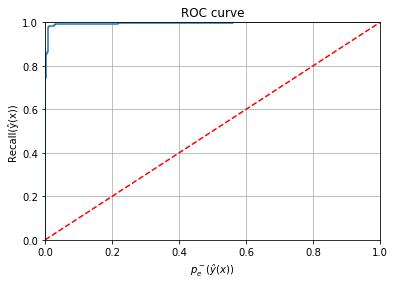

In [19]:
# plot curves
lin = np.linspace(0,1,1001)
plt.plot(fpr, tpr)
plt.plot(lin, lin, 'r--')
# labels
from matplotlib import rc
plt.xlabel('$p_e^-(ŷ(x))$')
plt.ylabel('Recall(ŷ(x))')
# title
plt.title('ROC curve')
# adjust plot
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.savefig(path + 'ROC', dpi=300)
plt.show()

In [20]:
F_score = []
threshold = np.linspace(0,1,1001)
for i in threshold:
    output = predict_class(ŷ, i)
    F_score.append(f1_score(y, output))

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


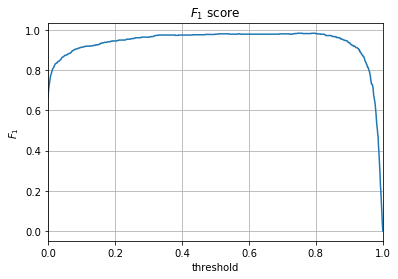

In [21]:
# plot curves
plt.plot(threshold, F_score)
# axis labels
plt.xlabel('threshold')
plt.ylabel('$F_1$')
# title
plt.title('$F_1$ score')
# adjust plot
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.savefig(path + 'F1_score', dpi=300)
plt.show()

In [22]:
index = F_score.index(max(F_score))
print('threshold for maximum F1 score =', threshold[index])
print('F1 score max =', F_score[index])

threshold for maximum F1 score = 0.745
F1 score max = 0.9841772151898733


In [23]:
ŷ_final = predict_class(ŷ, threshold[index])
confusion_matrix(y, ŷ_final)

array([[313,   4],
       [  6, 311]])

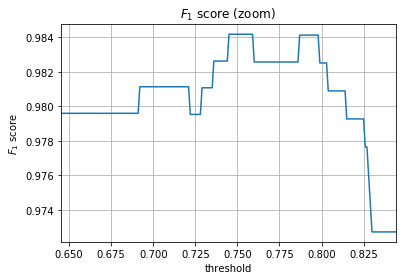

In [24]:
# plots
plt.plot(threshold[max(0,index-100):min(len(F_score)-1,index+100)], F_score[max(0,index-100):min(len(F_score)-1,index+100)])
# axis label
plt.xlabel('threshold')
plt.ylabel('$F_1$ score')
# axis adjust
plt.autoscale(axis='x', tight=True)
# title
plt.title('$F_1$ score (zoom)')
# add grid
plt.grid(True)
plt.savefig(path + 'F1_score_zoom', dpi=300)
plt.show()

In [25]:
accuracy_score(y, ŷ_final)

0.9842271293375394